<a href="https://colab.research.google.com/github/zubejda/Advanced_DL/blob/main/Assignment4_SelfSupervision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alternatvie text](https://www.doc.zuv.fau.de//M/FAU-Logo/01_FAU_Kernmarke/Web/FAU_Kernmarke_Q_RGB_blue.svg)


# Assignment 4: Self-Supervised Learning

In the lecture you have learned the main concept of Self-Supervised Learning, that is to derive supervision from proxy / surrogate tasks defined over the data. Over the past years, several proxy tasks have been developed to improve the performance of deep neural networks on downstream tasks. There are two main steps inolved in the self-supervision procedure. First, pre-training the backbone model on the pretext task. Next, the backbone model is finetuned on the downstream task.

In this assignment, you'll work on the task of microscopy image cell segmentation. You're required to implement a proxy task called "Pseudo-label microscopy image cell segmentation". This proxy task pre-trains a cell segmentation network using pseudo-cell segmentation maps extracted via classical computer vision operations. The below figure illustrates the training procedure.

<center><img src="pretrain.png"/></center>

<center><img src="finetune.png"/></center>

You'll need to install the following libraries:
- PyTorch
- Torchvision
- OpenCV
- Matplotlib

## 1. Data Preparation

First, you're required to download the microscopy image dataset, which you'll work with throughout this assignment. You can use this [link](https://github.com/unidesigner/groundtruth-drosophila-vnc) for download. The task involved in the dataset is binary cell segmentation, where the cells of interest are mitochondria. The microscopy images could be found in the directory "stack1/raw/" , while "stack1/mitochondria/" contains the corresponding binary cell segmentation groundtruth.

The dataset contains in total 20 images of resolution 1024x1024. It would be difficult to train on full resolution images, due to the high resolution. Alternatively, this issue could be solve by training with image crops. Note, the groundtruth should also be cropped at the same crop window location. The below class implements RandomCrop. Use a crop size of 256x256.

In [2]:
import torch
import random
import torchvision.transforms.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image, ImageDraw
import os
import cv2
import numpy as np
import subprocess
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from scipy import signal

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class RandomCrop(object):

    def __init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant'):

        self.size = size
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.fill = fill
        self.padding_mode = padding_mode

    @staticmethod
    def get_params(img, output_size):

        w, h = img.size
        th, tw = output_size
        if w == tw and h == th:
            return 0, 0, h, w

        i = random.randint(0, h - th)
        j = random.randint(0, w - tw)
        return i, j, th, tw

    def __call__(self, data):

        img, mask = data["image"], data["label"]
        # pad the width if needed
        if self.pad_if_needed and img.shape[0] < self.size[1]:
            img = F.pad(img, (self.size[1] - img.shape[0], 0), self.fill, self.padding_mode)
            mask = F.pad(mask, (self.size[1] - mask.shape[0], 0), self.fill, self.padding_mode)
        # pad the height if needed
        if self.pad_if_needed and img.shape[1] < self.size[0]:
            img = F.pad(img, (0, self.size[0] - img.shape[1]), self.fill, self.padding_mode)
            mask = F.pad(mask, (0, self.size[0] - mask.shape[1]), self.fill, self.padding_mode)
        done = False
        while not done:
            i, j, h, w = self.get_params(img, self.size)
            crop_image = F.crop(img, i, j, h, w)
            crop_mask = F.crop(mask, i, j, h, w)
            crop_image = np.array(crop_image)
            crop_mask = np.array(crop_mask)
            if np.sum(crop_mask==1, axis=0).sum() > int(0.1*h*w):
            # if (crop_mask==1).sum(dim=0).sum().item() > int(0.1*h*w):
                # print(i,j,h,w)
                return crop_image,crop_mask

Next, you will have to implement your own custom dataset to access the images during training and testing. The dataset will be split into 14 images for training and the rest for testing. You can pick the first 14 images for training, while use the rest for testing.

In [4]:
class DrosophilaDataset(Dataset):
    def __init__(self, repo_url='https://github.com/unidesigner/groundtruth-drosophila-vnc', local_dir='groundtruth-drosophila-vnc', transform=None, crop_size=(256, 256), training=1, pretraining=False):
        self.repo_url = repo_url
        self.local_dir = local_dir
        self.transform = transform
        self.training = training  # if we ant to load the training data 1, test data 2
        self.pretraining = pretraining
        self.clone_repo()
        self.crop_transform = RandomCrop(size=crop_size)
        self.images = self.get_image_files()
        self.annotations = self.load_annotations()

    def clone_repo(self):
        if not os.path.exists(self.local_dir):
            subprocess.run(['git', 'clone', self.repo_url])

    def get_image_files(self):
        img_files = []
        img_path = self.local_dir + '/stack' + str(self.training) + '/raw'
        for file in os.listdir(img_path):
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                img_files.append(os.path.join(img_path, file))

        random.shuffle(img_files)
        return img_files

    def load_annotations(self):
        annotations = {}
        annotations_path = self.local_dir + '/stack1/mitochondria'
        for file in os.listdir(annotations_path):
            key = file.split('.')[0]
            segmentation = Image.open(os.path.join(annotations_path, file))
            segmentation = np.array(segmentation)
            segmentation[segmentation>0] = 1  # ensures that the segmentation is binary
            annotations[key] = np.array(segmentation, dtype='bool')
        return annotations

    def extract_pseudo_labels(self, image):
        image = image.squeeze().astype(np.uint8)
        equalized = cv2.equalizeHist(image)
        _, thresholded = cv2.threshold(equalized, 140, 255, cv2.THRESH_BINARY_INV)
        pseudo_label = (thresholded > 0).astype(np.uint8)
        return pseudo_label


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
        im_type = image.dtype  # for conversion back to this type after transormation

        img_key = os.path.splitext(os.path.basename(img_path))[0]
        annotation = self.annotations.get(img_key, None)
        an_type = annotation.dtype

        if self.pretraining:
            annotation = self.extract_pseudo_labels(image)

        if self.transform:
            image = Image.fromarray(image)
            annotation = Image.fromarray(annotation)
            data = {"image": image, "label": annotation}
            image, annotation = self.crop_transform(data)
            image, annotation = np.array(image, dtype=im_type), np.array(annotation, dtype=an_type)

        image = np.expand_dims(image, axis=0)

        return image, annotation

    def visualize(self, img, ann, color=0, alpha=0.5):
        # if color = 0 segmentation is red, 1 is green, 2 is blue

        image = img.squeeze()

        seg_color = [0, 0, 0]
        seg_color[color] = 255
        segmentation_overlay = np.zeros(image.shape + (3,))
        segmentation_overlay[ann == 1] = seg_color

        image = np.stack((image,)*3, axis=-1)
        combined = (image * (1 - alpha) + segmentation_overlay * alpha).astype(np.uint8)
        plt.imshow(combined)
        plt.show()

## 2. Visualize Data

Visualize some of the microscopy data i.e. image and groundtruth without cropping.

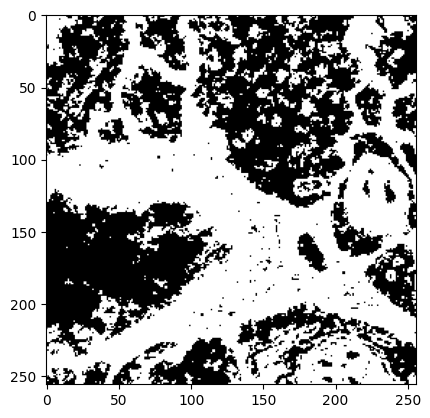

In [5]:
# visualization of the pseudo labels

dataset = DrosophilaDataset(transform=True, pretraining=True)
example_img, example_mask = dataset[0]
pseudo_label = dataset.extract_pseudo_labels(example_img)

plt.imshow(pseudo_label.squeeze(), cmap='gray')
plt.show()

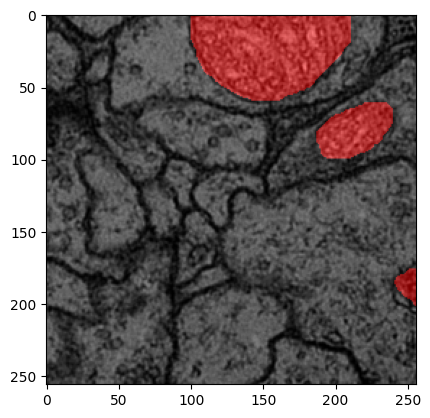

In [6]:
dataset = DrosophilaDataset(transform=True)
example_img, example_mask = dataset[0]
dataset.visualize(example_img, example_mask)

## 3. Supervised Learning (Learning from scratch)

In this part, you will train a fully convolutional regression network (FCRN) with randomly initialized weights and full supervision. Moreover, you should test the trained model on the test set. Use an Adam optimizer with 0.001 learning rate, train for 100 epochs and set the batch size to 14. Furthemore, you should use nn.BCEwithLogitsLoss(). Note since the number of pixels annotated as a foreground is much less than the background you should use weighted BCEloss i.e. nn.BCEwithLogitsLoss(weight=calc_weights(labels)).



In [7]:
def conv_bn_relu(in_channels, out_channels, kernel_size,affine=False):
    layer = []
    layer.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=False))
    layer.append(nn.BatchNorm2d(out_channels,affine=affine))
    layer.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layer)


def conv_bn_relu_transpose(in_channels, out_channels, kernel_size,affine=False):
    layer = []
    layer.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, bias=False))
    layer.append(nn.BatchNorm2d(out_channels,affine=affine))
    layer.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layer)

class FCRN(nn.Module):
    def __init__(self,in_channels=1, out_channels=32, kernel_size=3,affine=True):

        super(FCRN, self).__init__()
        # Encoder
        self.conv1 = conv_bn_relu(in_channels, out_channels, kernel_size,affine=affine)
        self.conv2 = conv_bn_relu(out_channels, out_channels * 2, kernel_size,affine=affine)
        self.conv3 = conv_bn_relu(out_channels * 2, out_channels * 4, kernel_size,affine=affine)

        self.maxpool = nn.MaxPool2d(2, 2)

        # LatentSpace
        self.conv4 = conv_bn_relu(out_channels * 4, out_channels * 16, kernel_size,affine=affine)

        # Decoder
        self.conv5 = conv_bn_relu_transpose(out_channels * 16, out_channels * 4, 2,affine=affine)
        self.conv6 = conv_bn_relu_transpose(out_channels * 4, out_channels * 2, 2,affine=affine)
        self.conv7 = conv_bn_relu_transpose(out_channels * 2, out_channels, 2,affine=affine)
        self.conv8 = nn.Conv2d(out_channels, in_channels, 3, padding=1)


        self._initialize_weights()
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.maxpool(self.conv2(x))
        x = self.maxpool(self.conv3(x))

        x = self.conv4(x)

        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        out = self.conv8(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            if isinstance(m,nn.ConvTranspose2d):
                init.normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

            elif isinstance(m, nn.BatchNorm2d):
                if m.affine:
                    init.constant_(m.weight, 0.1)
                    init.constant_(m.bias, 0)

In [8]:
def calc_weights(labels):
    pos_tensor = torch.ones_like(labels)

    for label_idx in range(0, labels.size(0)):
        pos_weight = torch.sum(labels[label_idx] == 1)
        neg_weight = torch.sum(labels[label_idx] == 0)
        ratio = float(neg_weight.item() / pos_weight.item())
        pos_tensor[label_idx] = ratio * pos_tensor[label_idx]

    return pos_tensor

To assess the segmentation performance, we will use the below function which calculate the mean intersection over union. For more information about the metric you can refer to this [blog](https://hasty.ai/docs/mp-wiki/metrics/iou-intersection-over-union#:~:text=To%20define%20the%20term%2C%20in,matches%20the%20ground%20truth%20data.).

In [9]:
def intersection_over_union(tensor, labels, device=torch.device("cpu")):
    iou = 0
    foreground_acc = 0

    labels_tens = labels.type(torch.BoolTensor)
    ones_tens = torch.ones_like(tensor, device=device)
    zeros_tens = torch.zeros_like(tensor, device=device)
    if tensor.shape[0] > 1:
        temp_tens = torch.where(tensor >= 0.5, ones_tens, zeros_tens)
        intersection_tens = (temp_tens.squeeze().type(torch.BoolTensor) & labels_tens.squeeze()).float().sum((1, 2))

        union_tens = (temp_tens.squeeze().type(torch.BoolTensor) | labels_tens.squeeze()).float().sum((1, 2))
        iou += torch.mean((intersection_tens + 0.0001) / (union_tens + 0.0001))
        foreground_acc += intersection_tens
    else:
        temp_tens = torch.where(tensor >= 0.5, ones_tens, zeros_tens)
        intersection_tens = (temp_tens.squeeze().type(torch.BoolTensor) & labels_tens.squeeze()).float().sum()
        union_tens = (temp_tens.squeeze().type(torch.BoolTensor) | labels_tens.squeeze()).float().sum()
        iou += torch.sum((intersection_tens + 0.0001) / (union_tens + 0.0001))
        foreground_acc += intersection_tens

    total_iou = iou
    return total_iou

In [10]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        inputs = torch.sigmoid(inputs)

        inputs = torch.flatten(inputs)
        targets = torch.flatten(targets)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [10]:
model = FCRN(in_channels=1, out_channels=32, kernel_size=3, affine=True).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

dice_criterion = DiceLoss()  # alternatively we can use dice loss or combine the two

# Create dataset and dataloaders
dataset = DrosophilaDataset(transform=True, training=1)
train_size = int(0.7 * len(dataset))  # 70 percent of the data is for training
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=14, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=14, shuffle=False)

num_epochs = 100
train_loss_history = []
val_loss_history = []
iou_history = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        weights = calc_weights(labels).to(device)
        bce_criterion = nn.BCEWithLogitsLoss(weight=weights)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = bce_criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss_history.append(running_loss/100)
        print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
        running_loss = 0.0

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            weights = calc_weights(labels).to(device)
            bce_criterion = nn.BCEWithLogitsLoss(weight=weights)

            outputs = model(inputs).squeeze()
            loss = bce_criterion(outputs, labels.float())

            outputs = outputs.cpu()
            iou = intersection_over_union(outputs, labels)
            iou_history.append(iou)

            val_loss += loss.item()
            val_loss_history.append(val_loss / len(val_loader))

    print(f"Epoch {epoch + 1} validation loss: {val_loss / len(val_loader):.3f}", f"IoU: {iou.item():.3f}")

print("Finished Training")

[Epoch 1, Batch 1] loss: 0.007
Epoch 1 validation loss: 8.814 IoU: 0.122
[Epoch 2, Batch 1] loss: 0.007
Epoch 2 validation loss: 4.552 IoU: 0.132
[Epoch 3, Batch 1] loss: 0.007
Epoch 3 validation loss: 2.837 IoU: 0.124
[Epoch 4, Batch 1] loss: 0.006
Epoch 4 validation loss: 1.990 IoU: 0.132
[Epoch 5, Batch 1] loss: 0.006
Epoch 5 validation loss: 1.476 IoU: 0.120
[Epoch 6, Batch 1] loss: 0.006
Epoch 6 validation loss: 1.137 IoU: 0.099
[Epoch 7, Batch 1] loss: 0.006
Epoch 7 validation loss: 0.934 IoU: 0.097
[Epoch 8, Batch 1] loss: 0.005
Epoch 8 validation loss: 0.791 IoU: 0.080
[Epoch 9, Batch 1] loss: 0.005
Epoch 9 validation loss: 0.677 IoU: 0.068
[Epoch 10, Batch 1] loss: 0.005
Epoch 10 validation loss: 0.585 IoU: 0.054
[Epoch 11, Batch 1] loss: 0.005
Epoch 11 validation loss: 0.526 IoU: 0.042
[Epoch 12, Batch 1] loss: 0.005
Epoch 12 validation loss: 0.484 IoU: 0.036
[Epoch 13, Batch 1] loss: 0.004
Epoch 13 validation loss: 0.496 IoU: 0.029
[Epoch 14, Batch 1] loss: 0.004
Epoch 14 va

Plot the train loss and the train mIoU. You should get a test mIoU of about 45%.

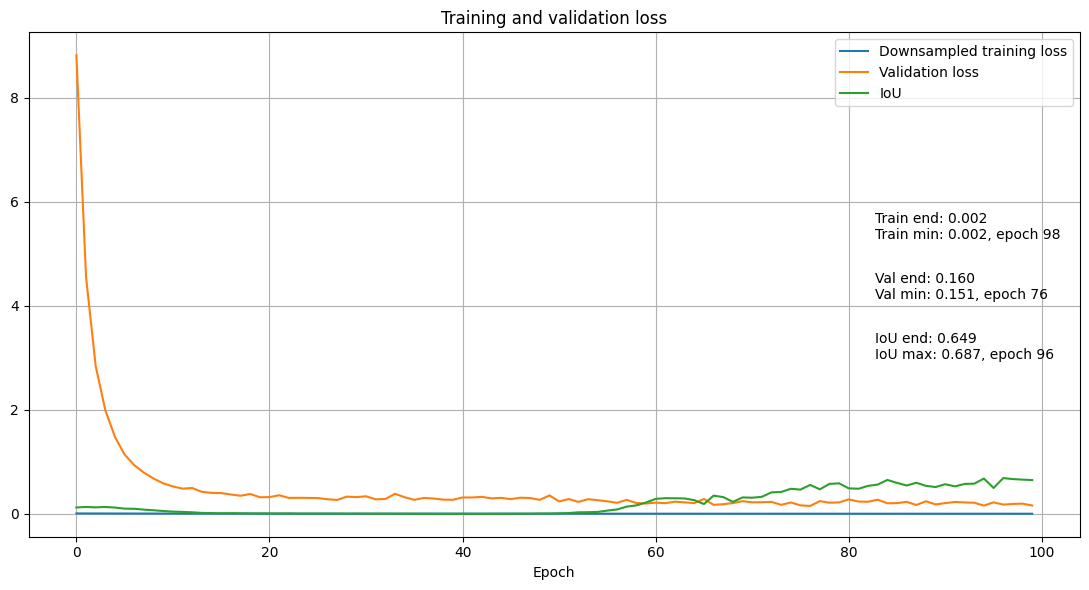

In [11]:
downsampling_factor = len(train_loss_history) // len(val_loss_history)
train_loss_downsampled = signal.decimate(train_loss_history, downsampling_factor)
train_loss_downsampled = train_loss_downsampled[:len(val_loss_history)]

x = range(len(val_loss_history))

plt.figure(figsize=(11, 6))
plt.plot(x, train_loss_downsampled, label='Downsampled training loss')
plt.plot(x, val_loss_history, label='Validation loss')
plt.plot(x, iou_history, label="IoU")

# Create placeholders for the legend-like area
train_legend_text = f'Train end: {train_loss_downsampled[-1]:.3f}\n'
val_legend_text = f'Val end: {val_loss_history[-1]:.3f}\n'
iou_legend_text = f'IoU end: {iou_history[-1]:.3f}\n'

# Find and store min/max values
for data, label in zip([train_loss_downsampled, val_loss_history, iou_history],
                       ['Train', 'Val', 'IoU']):
    i = np.argmin(np.array(data))
    s = 'min'
    if label == "IoU":
        i = np.argmax(np.array(data))
        s = 'max'

    if label == 'Train':
        train_legend_text += f'Train {s}: {data[i]:.3f}, epoch {i}\n'
    elif label == 'Val':
        val_legend_text += f'Val {s}: {data[i]:.3f}, epoch {i}\n'
    elif label == 'IoU':
        iou_legend_text += f'IoU {s}: {data[i]:.3f}, epoch {i}\n'

# Add the legend-like text outside the plot
plt.figtext(0.8, 0.6, train_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)
plt.figtext(0.8, 0.5, val_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)
plt.figtext(0.8, 0.4, iou_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)

plt.xlabel('Epoch')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

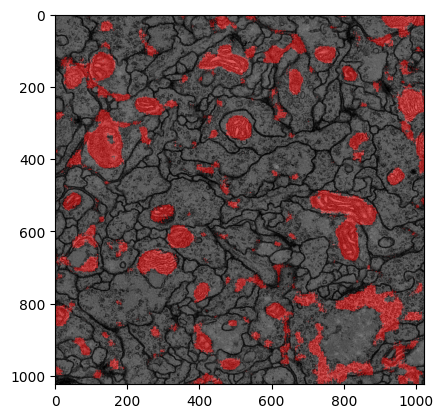

In [12]:
test_dataset = DrosophilaDataset(transform=False, training=2)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
index = np.random.randint(0, len(test_dataset))

test_example = test_dataset[index]
images = torch.from_numpy(np.expand_dims(test_example[0], axis=0))
images = images.to(device)
outputs = model(images)

image = images.squeeze().cpu()
mask = outputs.squeeze().cpu()
# print(image.shape, mask.shape)
mask[mask>0] = 1
mask[mask<0] = 0

test_dataset.visualize(image, mask)

## 4. Self-Supervised Learning

Here you will implement a function which extracts pseudo-cell segmentation maps to train your model on the pretext task. You will use the images of the training set to extract pseudo-labels and you should use the pseudo-labels as your target when calculating the loss. Modify your custom dataset class to extract pseudo-labels during pre-training.

To extract pseudo-labels, you can use OpenCV and follow these steps:
- Convert Image to GrayScale cv2.cvtColor().
- Apply histogram equalization i.e. cv2.equalizeHist().
- Apply binary inversion threshold i.e. cv2.THRESH_BIN_INV, use threshold range of [140, 170].
- Convert all values greater than 0 to 255 and 0 otherwise.

In [13]:
def extract_pseudo_labels():
    pass

Afterwards, you will pre-train your model on the pseudo-label cell segmentation learning with same optimizer, batch, and loss function. However, pretrain only for 50 epochs. Then you will fine-tune the entire pretrained model (encoder and decoder) for 100 epochs assuming you have now access to the groundtruth of the data. You should notice an improvement in the test mIoU of about 10%.

In [12]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Pre-training Loop
model = FCRN(in_channels=1, out_channels=32, kernel_size=3, affine=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

pretrain_dataset = DrosophilaDataset(transform=True, training=1, pretraining=True)
train_size = int(0.7 * len(pretrain_dataset))  # 70 percent of the data is for training
val_size = len(pretrain_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(pretrain_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=14, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=14, shuffle=False)

train_loss_history = []
val_loss_history = []
iou_history = []

num_pretrain_epochs = 50
for epoch in range(num_pretrain_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        weights = calc_weights(labels).to(device)
        bce_criterion = nn.BCEWithLogitsLoss(weight=weights)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = bce_criterion(outputs, labels.float())
        # loss = dice_criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loss_history.append(running_loss / 100)
        print(f"[Pretrain Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
        running_loss = 0.0

    # Validation loop
    model.eval()
    val_loss = 0.0
    iou_total = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            labels = labels.float()

            weights = calc_weights(labels).to(device)
            bce_criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

            outputs = model(inputs).squeeze()
            loss = bce_criterion(outputs, labels)
            val_loss += loss.item()

            outputs = outputs.cpu()
            iou = intersection_over_union(outputs, labels.cpu())
            iou_total += iou.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_iou = iou_total / len(val_loader)
        val_loss_history.append(avg_val_loss)
        iou_history.append(avg_iou)

    print(f"Pretrain Epoch {epoch + 1} validation loss: {avg_val_loss:.3f} IoU: {avg_iou:.3f}")

print("Finished Pre-Training")

[Pretrain Epoch 1, Batch 1] loss: 0.008
Pretrain Epoch 1 validation loss: 10.336 IoU: 0.488
[Pretrain Epoch 2, Batch 1] loss: 0.008
Pretrain Epoch 2 validation loss: 5.527 IoU: 0.465
[Pretrain Epoch 3, Batch 1] loss: 0.007
Pretrain Epoch 3 validation loss: 3.318 IoU: 0.484
[Pretrain Epoch 4, Batch 1] loss: 0.007
Pretrain Epoch 4 validation loss: 2.255 IoU: 0.490
[Pretrain Epoch 5, Batch 1] loss: 0.007
Pretrain Epoch 5 validation loss: 1.724 IoU: 0.465
[Pretrain Epoch 6, Batch 1] loss: 0.007
Pretrain Epoch 6 validation loss: 1.341 IoU: 0.460
[Pretrain Epoch 7, Batch 1] loss: 0.007
Pretrain Epoch 7 validation loss: 1.096 IoU: 0.447
[Pretrain Epoch 8, Batch 1] loss: 0.007
Pretrain Epoch 8 validation loss: 0.908 IoU: 0.449
[Pretrain Epoch 9, Batch 1] loss: 0.006
Pretrain Epoch 9 validation loss: 0.816 IoU: 0.444
[Pretrain Epoch 10, Batch 1] loss: 0.006
Pretrain Epoch 10 validation loss: 0.708 IoU: 0.435
[Pretrain Epoch 11, Batch 1] loss: 0.006
Pretrain Epoch 11 validation loss: 0.664 IoU: 

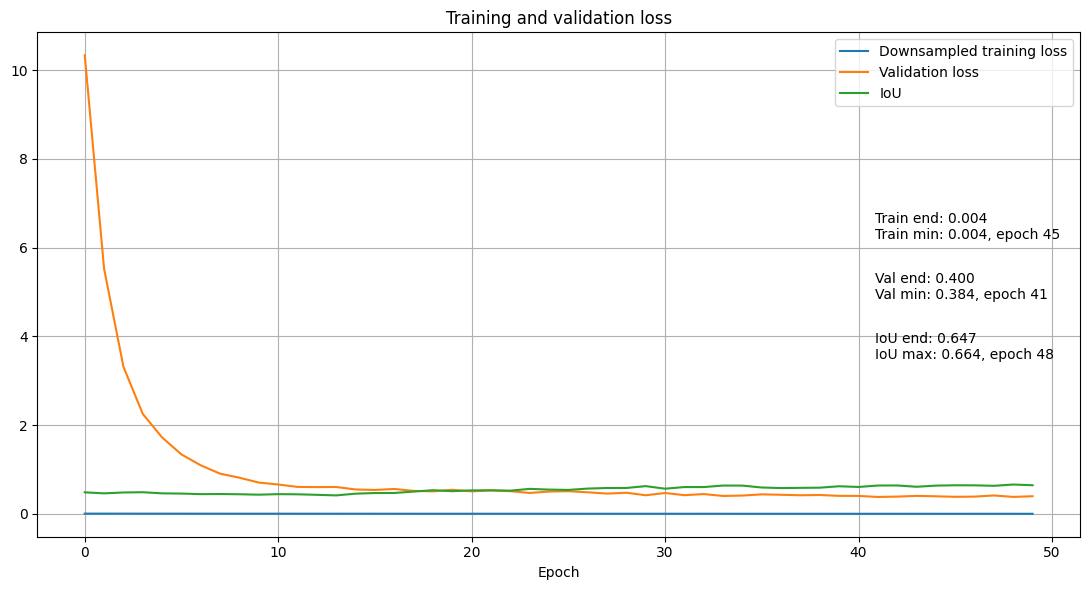

In [13]:
# plots of the losses and metrics for the pretraining task

downsampling_factor = len(train_loss_history) // len(val_loss_history)
train_loss_downsampled = signal.decimate(train_loss_history, downsampling_factor)
train_loss_downsampled = train_loss_downsampled[:len(val_loss_history)]

x = range(len(val_loss_history))

plt.figure(figsize=(11, 6))
plt.plot(x, train_loss_downsampled, label='Downsampled training loss')
plt.plot(x, val_loss_history, label='Validation loss')
plt.plot(x, iou_history, label="IoU")

# Create placeholders for the legend-like area
train_legend_text = f'Train end: {train_loss_downsampled[-1]:.3f}\n'
val_legend_text = f'Val end: {val_loss_history[-1]:.3f}\n'
iou_legend_text = f'IoU end: {iou_history[-1]:.3f}\n'

# Find and store min/max values
for data, label in zip([train_loss_downsampled, val_loss_history, iou_history],
                       ['Train', 'Val', 'IoU']):
    i = np.argmin(np.array(data))
    s = 'min'
    if label == "IoU":
        i = np.argmax(np.array(data))
        s = 'max'

    if label == 'Train':
        train_legend_text += f'Train {s}: {data[i]:.3f}, epoch {i}\n'
    elif label == 'Val':
        val_legend_text += f'Val {s}: {data[i]:.3f}, epoch {i}\n'
    elif label == 'IoU':
        iou_legend_text += f'IoU {s}: {data[i]:.3f}, epoch {i}\n'

# Add the legend-like text outside the plot
plt.figtext(0.8, 0.6, train_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)
plt.figtext(0.8, 0.5, val_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)
plt.figtext(0.8, 0.4, iou_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)

plt.xlabel('Epoch')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

In [15]:
# Fine tune entire model

optimizer.param_groups[0]['lr'] = 0.0007  # decrease in the learning rate should hopefully should smooth out the loss
optimizer.param_groups[0]['weight_decay'] = 0.0001
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

finetune_dataset = DrosophilaDataset(transform=True, training=1, pretraining=False)
train_size = int(0.7 * len(finetune_dataset))  # 70 percent of the data is for training
val_size = len(finetune_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(finetune_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=14, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=14, shuffle=False)

train_loss_history = []
val_loss_history = []
iou_history = []

num_finetune_epochs = 100
for epoch in range(num_finetune_epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        weights = calc_weights(labels).to(device)
        bce_criterion = nn.BCEWithLogitsLoss(weight=weights)

        optimizer.zero_grad()

        outputs = model(inputs).squeeze()
        loss = bce_criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loss_history.append(running_loss/100)
        print(f"[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}")
        running_loss = 0.0

    # Validation loop
    model.eval()
    val_loss = 0.0
    iou_total = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            labels = labels.float()

            weights = calc_weights(labels).to(device)
            bce_criterion = nn.BCEWithLogitsLoss(pos_weight=weights)

            outputs = model(inputs).squeeze()
            loss = bce_criterion(outputs, labels)
            val_loss += loss.item()

            outputs = outputs.cpu()
            iou = intersection_over_union(outputs, labels.cpu())
            iou_total += iou.item()

        avg_val_loss = val_loss / len(val_loader)
        avg_iou = iou_total / len(val_loader)
        val_loss_history.append(avg_val_loss)
        iou_history.append(avg_iou)

    print(f"Finetune Epoch {epoch + 1} validation loss: {avg_val_loss:.3f} IoU: {avg_iou:.3f}")

print("Finished Fine-Tuning")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


[Epoch 1, Batch 1] loss: 0.010
Finetune Epoch 1 validation loss: 1.092 IoU: 0.260
[Epoch 2, Batch 1] loss: 0.010
Finetune Epoch 2 validation loss: 1.027 IoU: 0.326
[Epoch 3, Batch 1] loss: 0.009
Finetune Epoch 3 validation loss: 1.043 IoU: 0.308
[Epoch 4, Batch 1] loss: 0.009
Finetune Epoch 4 validation loss: 0.916 IoU: 0.356
[Epoch 5, Batch 1] loss: 0.009
Finetune Epoch 5 validation loss: 1.005 IoU: 0.271
[Epoch 6, Batch 1] loss: 0.008
Finetune Epoch 6 validation loss: 0.849 IoU: 0.329
[Epoch 7, Batch 1] loss: 0.008
Finetune Epoch 7 validation loss: 0.880 IoU: 0.328
[Epoch 8, Batch 1] loss: 0.007
Finetune Epoch 8 validation loss: 0.925 IoU: 0.307
[Epoch 9, Batch 1] loss: 0.007
Finetune Epoch 9 validation loss: 0.855 IoU: 0.313
[Epoch 10, Batch 1] loss: 0.007
Finetune Epoch 10 validation loss: 0.827 IoU: 0.330
[Epoch 11, Batch 1] loss: 0.006
Finetune Epoch 11 validation loss: 0.740 IoU: 0.396
[Epoch 12, Batch 1] loss: 0.006
Finetune Epoch 12 validation loss: 0.779 IoU: 0.358
[Epoch 13,

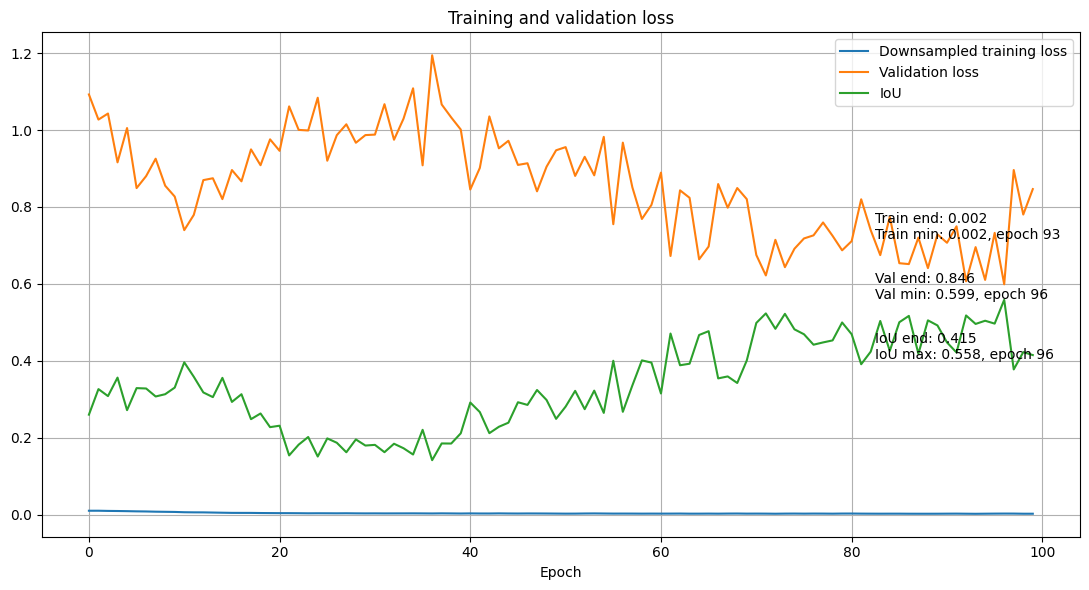

In [16]:
# plots of the losses and metrics

downsampling_factor = len(train_loss_history) // len(val_loss_history)
train_loss_downsampled = signal.decimate(train_loss_history, downsampling_factor)
train_loss_downsampled = train_loss_downsampled[:len(val_loss_history)]

x = range(len(val_loss_history))

plt.figure(figsize=(11, 6))
plt.plot(x, train_loss_downsampled, label='Downsampled training loss')
plt.plot(x, val_loss_history, label='Validation loss')
plt.plot(x, iou_history, label="IoU")

# Create placeholders for the legend-like area
train_legend_text = f'Train end: {train_loss_downsampled[-1]:.3f}\n'
val_legend_text = f'Val end: {val_loss_history[-1]:.3f}\n'
iou_legend_text = f'IoU end: {iou_history[-1]:.3f}\n'

# Find and store min/max values
for data, label in zip([train_loss_downsampled, val_loss_history, iou_history],
                       ['Train', 'Val', 'IoU']):
    i = np.argmin(np.array(data))
    s = 'min'
    if label == "IoU":
        i = np.argmax(np.array(data))
        s = 'max'

    if label == 'Train':
        train_legend_text += f'Train {s}: {data[i]:.3f}, epoch {i}\n'
    elif label == 'Val':
        val_legend_text += f'Val {s}: {data[i]:.3f}, epoch {i}\n'
    elif label == 'IoU':
        iou_legend_text += f'IoU {s}: {data[i]:.3f}, epoch {i}\n'

# Add the legend-like text outside the plot
plt.figtext(0.8, 0.6, train_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)
plt.figtext(0.8, 0.5, val_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)
plt.figtext(0.8, 0.4, iou_legend_text, horizontalalignment='left', verticalalignment='center', fontsize=10)

plt.xlabel('Epoch')
plt.title('Training and validation loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()

plt.show()

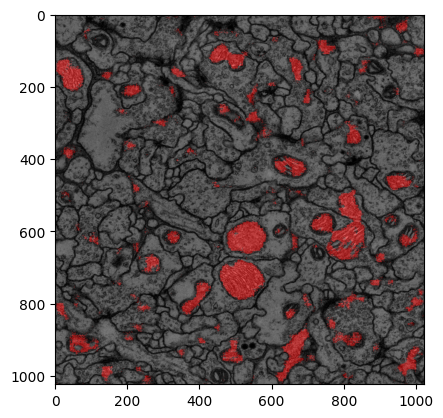

In [17]:
# vizualizing predictions

test_dataset = DrosophilaDataset(transform=False, training=2)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
index = np.random.randint(0, len(test_dataset))

test_example = test_dataset[index]
images = torch.from_numpy(np.expand_dims(test_example[0], axis=0))
images = images.to(device)
outputs = model(images)

image = images.squeeze().cpu()
mask = outputs.squeeze().cpu()
# print(image.shape, mask.shape)
mask[mask>0] = 1
mask[mask<0] = 0

test_dataset.visualize(image, mask)